# Predicting with real cases

## Loading the model and the binarizer

In [ ]:
# Inference example: load saved model and predict one image from input/plantvillage
import tensorflow as tf
import pickle
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths (adjust if your files are in a different folder)
MODEL_PATH = 'plant_disease_cnn.keras'
LABEL_BINARIZER_PATH = 'label_transform.pkl'
DATA_ROOT = Path('input/plantvillage/')
ALLOWED_EXTS = {'.jpg', '.jpeg', '.png', '.bmp'}

# Load model
print(f"Loading model from {MODEL_PATH}...")
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print('Model loaded')

# Load label binarizer
try:
    with open(LABEL_BINARIZER_PATH, 'rb') as f:
        label_binarizer = pickle.load(f)
    classes = list(label_binarizer.classes_)
    print(f"Loaded {len(classes)} classes")
except Exception as e:
    print('Could not load label binarizer:', e)
    label_binarizer = None
    classes = None


Loading model from plant_disease_cnn.keras...
Model loaded
Model loaded


## Predicting labels

Loaded 15 classes
Using image: input/plantvillage/Tomato_Late_blight/127f2df5-4da2-40ef-ba65-91a732f2498e___GHLB_PS Leaf 40.1 Day 18.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Top predictions:
 - Tomato_Late_blight: 0.9910
 - Potato___Late_blight: 0.0031
 - Tomato__Tomato_mosaic_virus: 0.0020

Top predictions:
 - Tomato_Late_blight: 0.9910
 - Potato___Late_blight: 0.0031
 - Tomato__Tomato_mosaic_virus: 0.0020


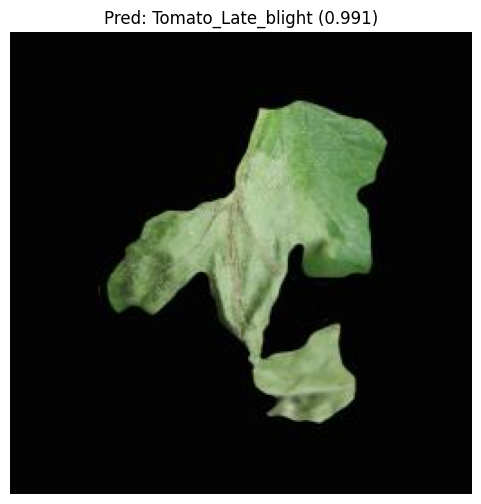

In [ ]:
# Find one image under input/plantvillage (search recursively)
img_path = None
if DATA_ROOT.exists():
    for ext in ALLOWED_EXTS:
        # use rglob to search recursively
        it = DATA_ROOT.rglob(f'*{ext}')
        for p in it:
            img_path = p
            break
        if img_path is not None:
            break

# fallback: search top-level input if nothing found
if img_path is None:
    print('No image found under input/plantvillage; searching input/ ...')
    root2 = Path('input')
    if root2.exists():
        for ext in ALLOWED_EXTS:
            it = root2.rglob(f'*{ext}')
            for p in it:
                img_path = p
                break
            if img_path is not None:
                break

if img_path is None:
    raise FileNotFoundError('No image files found under input/plantvillage or input/')

print('Using image:', img_path)

# Read and preprocess image according to model input shape
img = cv2.imread(str(img_path))
if img is None:
    raise RuntimeError(f'Failed to read image: {img_path}')
# Convert BGR->RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Determine target size from model (if available)
input_shape = None
try:
    ishape = model.input_shape  # (None, H, W, C) or similar
    if ishape is not None and len(ishape) >= 3 and ishape[1] is not None and ishape[2] is not None:
        target_h, target_w = int(ishape[1]), int(ishape[2])
        input_shape = (target_h, target_w)
except Exception:
    input_shape = None

if input_shape is None:
    target_h, target_w = 256, 256
    print('Model input shape unknown - falling back to 256x256')

resized = cv2.resize(img_rgb, (target_w, target_h))
arr = resized.astype('float32') / 255.0
batch = np.expand_dims(arr, axis=0)

# Predict
probs = model.predict(batch)
probs = np.asarray(probs)
# if model outputs logits, apply softmax
if probs.ndim == 2 and not np.all((probs >= 0) & (probs <= 1)):
    # try softmax
    exp = np.exp(probs - np.max(probs, axis=1, keepdims=True))
    probs = exp / np.sum(exp, axis=1, keepdims=True)

topk = np.argsort(probs[0])[::-1][:3]
print('\nTop predictions:')
for idx in topk:
    label = classes[idx] if classes is not None else str(idx)
    print(f' - {label}: {probs[0, idx]:.4f}')

# Show image with top prediction in title
pred_label = classes[topk[0]] if classes is not None else str(topk[0])
plt.figure(figsize=(6,6))
plt.imshow(resized)
plt.title(f"Pred: {pred_label} ({probs[0, topk[0]]:.3f})")
plt.axis('off')
plt.show()